---

### FILL IN YOUR FOLDER TO ANALYSE HERE

In [1]:
DATA_FOLDER = None

---

In [2]:
import json          
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import numpy as np
import sys
from pathlib import Path
from rich.console import Console

In [3]:
console = Console()                                                                                                                                                                                                                                                        
sys.path.insert(0, str(Path.cwd().parent))                                                                                                                                                                                                                                 
from ea.config import Config 

if not DATA_FOLDER:
    df = pd.read_csv('run_history.csv')
    DATA_FOLDER = df['output_folder'].iloc[-1]
    
data = pd.read_sql("SELECT * FROM individual", sqlite3.connect(f"{DATA_FOLDER}/database.db"))
config = Config.load(DATA_FOLDER)
config.large_description()

                       EA Configuration (Full)                        
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Setting            ┃ Value                          ┃ Type         ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ SEED               │ 42                             │ int          │
│ RUN_NAME           │ tour_and_archive               │ str          │
│ QUIET              │ ✗                              │ bool         │
│ STORE_STRING       │ ✓                              │ bool         │
│ NUM_MODULES        │ 20                             │ int          │
│ GENOTYPE_SIZE      │ 64                             │ int          │
│ SCALE              │ 8192.0                         │ float        │
│ REV_SCALING_FACTOR │ -0.5                           │ float        │
│ POPULATION_SIZE    │ 10                             │ int          │
│ NUM_GENERATIONS    │ 10                             │ int          │
│ IS_MAXIMISATION    │ ✓                              │ bool         │
│ FITNESS_NOVELTY    │ ✓                              │ bool         │
│ FITNESS_SPEED      │ ✗                              │ bool         │
│ STORE_NOVELTY      │ ✓                              │ bool | None  │
│ STORE_SPEED        │ ✗                              │ bool | None  │
│ TOURNAMENT         │ ✗                              │ bool         │
│ K_TOURNAMENT       │ 2                              │ int          │
│ SIM_SPACE          │                                │ <enum 'Space │
│ MAX_HOP_RADIUS     │ None                           │ int | None   │
│ K_NOVELTY          │ 1                              │ int          │
│ ARCHIVE_CHANCE     │ 0.1                            │ float        │
│ OUTPUT_FOLDER      │ __data__/tour_and_archive_0005 │ pathlib.Path │
└────────────────────┴────────────────────────────────┴──────────────┘

In [4]:
tags_expanded = data['tags_'].apply(lambda x: json.loads(x) if isinstance(x, str) else x).apply(pd.Series)                                        
data = pd.concat([data, tags_expanded], axis=1)                                                                                                   
                                                                                                                                                                                                                                                     
data['gen'] = data.apply(                                                                                                                         
    lambda row: list(range(int(row['time_of_birth']), int(row['time_of_death']) + 1)),                                                            
    axis=1                                                                                                                                        
)                                                                                                                                                 

gen_df = (data                                                                                                                                    
    .explode('gen')                                                                                                                               
    .rename(columns={'fitness_': 'fitness', 'genotype_': 'genotype', 'tags_': 'tags'})                                     
    .sort_values(['gen', 'fitness'], ascending=[True, not config.IS_MAXIMISATION])                                                                
)                                                                                                                                                 
                                                                                                                                                
# Add rank within each generation                                                                                                                 
gen_df['rank'] = gen_df.groupby('gen').cumcount()                                                                                                 
                                                                                                                                                
gen_df = gen_df.set_index(['gen', 'rank'])
gen_df.head()

id  alive  time_of_birth  time_of_death  requires_eval   fitness  \
gen rank                                                                     
0   0      3      1              0             10              0  0.908699   
    1     10      1              0             10              0  0.903340   
    2      6      1              0             10              0  0.902452   
    3      1      0              0              2              0  0.901868   
    4      9      0              0              2              0  0.900272   

          requires_init                                           genotype  \
gen rank                                                                     
0   0                 0  [[-2025.7263864901433, 7972.971232040092, 3567...   
    1                 0  [[-7685.851758001649, -1696.7887197829186, 729...   
    2                 0  [[599.1303344470307, -1072.1184203130415, -603...   
    3                 0  [[4488.495899540903, -1001.4156431023748, 5875...   
    4                 0  [[4623.748223267554, 4063.0702727568896, 5162....   

                                                       tags  \
gen rank                                                      
0   0     {"ctk_string": "C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(...   
    1     {"ctk_string": "C[f(H7H7)]<b(B[r(B6)l(B6[t(B5[...   
    2     {"ctk_string": "C[f(B2[r(B2)]B[t(B6[t(B2)]H)r(...   
    3     {"ctk_string": "C[f(H5H4H6)]<b(B5[l(B[l(B2[r(B...   
    4     {"ctk_string": "C[f(H4H5HB6[l(B6[l(B5)]H7H1)b(...   

                                                 ctk_string   novelty archived  
gen rank                                                                        
0   0     C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(B6[b(B6H4)]B1H2H...  0.908699      NaN  
    1     C[f(H7H7)]<b(B[r(B6)l(B6[t(B5[l(B6H5H4)t(B7H7)...  0.903340      NaN  
    2      C[f(B2[r(B2)]B[t(B6[t(B2)]H)r(B[t(B6H6)]H5H6)])]  0.902452     True  
    3     C[f(H5H4H6)]<b(B5[l(B[l(B2[r(B7)])t(B3H4)r(B6H...  0.901868      NaN  
    4       C[f(H4H5HB6[l(B6[l(B5)]H7H1)b(B[r(B2)b(B6)])])]  0.900272     True

In [5]:
import matplotlib.pyplot as plt                                                                                                                   
                                                                                                                                                    
def plot_generation_stats(gen_df, column, config, title=None):                                                                                    
    """Plot best/worst/mean/std of a column across generations."""                                                                                
    stats = gen_df.groupby('gen')[column].agg(['mean', 'min', 'max', 'std'])                                                                      
                                                                                                                                                
    # Determine best/worst based on maximisation                                                                                                  
    if config.IS_MAXIMISATION:                                                                                                                    
        best, worst = stats['max'], stats['min']                                                                                                  
    else:                                                                                                                                         
        best, worst = stats['min'], stats['max']                                                                                                  
                                                                                                                                                
    fig, ax = plt.subplots(figsize=(10, 6))                                                                                                       
                                                                                                                                                
    # Mean line                                                                                                                                   
    ax.plot(stats.index, stats['mean'], label='Mean', color='blue', linewidth=2)                                                                  
                                                                                                                                                
    # Std shaded area                                                                                                                             
    ax.fill_between(stats.index,                                                                                                                  
                    stats['mean'] - stats['std'],                                                                                                 
                    stats['mean'] + stats['std'],                                                                                                 
                    alpha=0.2, color='blue', label='±1 Std')                                                                                      
                                                                                                                                                
    # Best/Worst lines                                                                                                                            
    ax.plot(stats.index, best, '--', label='Best', color='green')                                                                                 
    # ax.plot(stats.index, worst, '--', label='Worst', color='red')                                                                                 
                                                                                                                                                
    ax.set_xlabel('Generation')                                                                                                                   
    ax.set_ylabel(column)                                                                                                                         
    ax.set_title(title or f'{column} over Generations')                                                                                           
    ax.legend()                                                                                                                                   
    ax.grid(True, alpha=0.3)                                                                                                                      
                                                                                                                                                
    plt.tight_layout()                                                                                                                            
    return fig, ax                                                                                                                                
                                                                                                                                                                                                                                                      
                                                                                                                                                
def plot_multiple_stats(gen_df, columns, config):                                                                                                 
    """Plot stats for multiple columns in subplots."""                                                                                            
    fig, axes = plt.subplots(len(columns), 1, figsize=(10, 4*len(columns)), sharex=True)                                                          
    if len(columns) == 1:                                                                                                                         
        axes = [axes]                                                                                                                             
                                                                                                                                                
    for ax, col in zip(axes, columns):                                                                                                            
        stats = gen_df.groupby('gen')[col].agg(['mean', 'min', 'max', 'std'])                                                                     
                                                                                                                                                
        if config.IS_MAXIMISATION:                                                                                                                
            best, worst = stats['max'], stats['min']                                                                                              
        else:                                                                                                                                     
            best, worst = stats['min'], stats['max']                                                                                              
                                                                                                                                                
        ax.plot(stats.index, stats['mean'], label='Mean', color='blue')                                                                           
        ax.fill_between(stats.index, stats['mean']-stats['std'], stats['mean']+stats['std'], alpha=0.2)                                           
        ax.plot(stats.index, best, '--', color='green', label='Best')                                                                             
        ax.plot(stats.index, worst, '--', color='red', label='Worst')                                                                             
        ax.set_ylabel(col)                                                                                                                        
        ax.legend(loc='upper right')                                                                                                              
        ax.grid(True, alpha=0.3)                                                                                                                  
                                                                                                                                                
    axes[-1].set_xlabel('Generation')                                                                                                             
    plt.tight_layout()                                                                                                                            
    return fig, axes  

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'fitness over Generations'}, xlabel='Generation', ylabel='fitness'>)

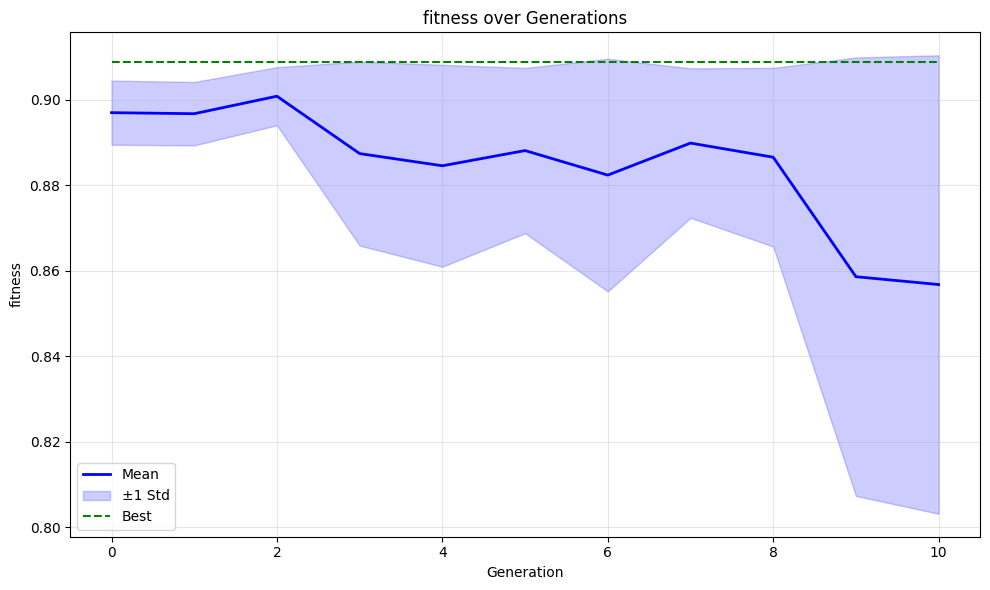

In [6]:
# Usage                                                                                                                                           
plot_generation_stats(gen_df, 'fitness', config)                                                                                                  
                                                                                                                                                

In [7]:
import matplotlib.pyplot as plt                                                                                                                   
import matplotlib.cm as cm

def plot_top_lifespans(gen_df, config, column='fitness', top_x=20, title=None):                                                                   
      """Plot lifespan of top X individuals across generations."""                                                                                  
                                                                                                                                                    
      # Get unique individuals with their stats                                                                                                     
      individuals = (gen_df                                                                                                                         
          .reset_index()                                                                                                                            
          .groupby('id')                                                                                                                 
          .agg({                                                                                                                                    
              column: 'first',  # Their fitness (same across all their rows)                                                                        
              'gen': ['min', 'max']  # Birth and death                                                                                              
          })                                                                                                                                        
      )                                                                                                                                             
      individuals.columns = [column, 'birth', 'death']                                                                                              
                                                                                                                                                    
      # Sort by fitness and get top X                                                                                                               
      ascending = not config.IS_MAXIMISATION                                                                                                        
      top_individuals = individuals.sort_values(column, ascending=ascending).head(top_x)                                                            
                                                                                                                                                    
      # Plot                                                                                                                                        
      fig, ax = plt.subplots(figsize=(12, 6))                                                                                                       
                                                                                                                                                    
      # Color map based on fitness                                                                                                                  
      colors = cm.viridis(np.linspace(0, 1, top_x))                                                                                                 
                                                                                                                                                    
      for i, (ind_id, row) in enumerate(top_individuals.iterrows()):                                                                                
          # Horizontal line from birth to death                                                                                                     
          ax.hlines(y=row[column], xmin=row['birth'], xmax=row['death'],                                                                            
                    color=colors[i], linewidth=3, alpha=0.7)                                                                                        
                                                                                                                                                    
          # Markers for birth (circle) and death (x)                                                                                                
          ax.scatter(row['birth'], row[column], color=colors[i], s=100, marker='o', zorder=5)                                                       
          ax.scatter(row['death'], row[column], color=colors[i], s=100, marker='X', zorder=5)                                                       
                                                                                                                                                    
          # Label with individual ID                                                                                                                
          ax.annotate(f'{int(ind_id)}', (row['death'] + 0.3, row[column]),                                                                          
                      fontsize=8, va='center')                                                                                                      
                                                                                                                                                    
      ax.set_xlabel('Generation')                                                                                                                   
      ax.set_ylabel(column)                                                                                                                         
      ax.set_title(title or f'Lifespan of Top {top_x} Individuals')                                                                                 
      ax.grid(True, alpha=0.3)                                                                                                                      
                                                                                                                                                    
      # Add legend                                                                                                                                  
      from matplotlib.lines import Line2D                                                                                                           
      legend_elements = [                                                                                                                           
          Line2D([0], [0], marker='o', color='gray', label='Birth', markersize=8, linestyle=''),                                                    
          Line2D([0], [0], marker='X', color='gray', label='Death', markersize=8, linestyle=''),                                                    
      ]                                                                                                                                             
      ax.legend(handles=legend_elements, loc='lower right')                                                                                         
                                                                                                                                                    
      plt.tight_layout()                                                                                                                            
      return fig, ax                                                                                                                                
                                                                                                                                                    
# Usage                                                                                                                                           
import numpy as np                                                                                                                                
# plot_top_lifespans(gen_df, config, column='fitness', top_x=300) 

In [8]:
import matplotlib.pyplot as plt                                                                                                                   
import matplotlib.cm as cm                                                                                                                        
import numpy as np                                                                                                                                
                                                                                                                                                
def plot_top_lifespans(gen_df, config, column='fitness', top_x=5, title=None):                                                                    
    """Plot lifespan of individuals who were ever in top X of any generation."""                                                                  
                                                                                                                                                
    df = gen_df.reset_index()                                                                                                                     
                                                                                                                                                
    # For each generation, get the top X individual IDs                                                                                           
    top_per_gen = (df                                                                                                                             
        .sort_values([column], ascending=not config.IS_MAXIMISATION)                                                                              
        .groupby('gen')                                                                                                                           
        .head(top_x)                                                                                                                              
    )                                                                                                                                             
                                                                                                                                                
    # Get all unique individuals who were ever in top X                                                                                           
    top_individuals = top_per_gen['id'].unique()                                                                                       
                                                                                                                                                
    # Get their full lifespan data                                                                                                                
    lifespan_data = (df[df['id'].isin(top_individuals)]                                                                                
        .groupby('id')                                                                                                                 
        .agg({                                                                                                                                    
            column: 'first',                                                                                                                      
            'gen': ['min', 'max']                                                                                                                 
        })                                                                                                                                        
    )                                                                                                                                             
    lifespan_data.columns = [column, 'birth', 'death']                                                                                            
    lifespan_data = lifespan_data.sort_values(column, ascending=not config.IS_MAXIMISATION)                                                       
                                                                                                                                                
    # Plot                                                                                                                                        
    fig, ax = plt.subplots(figsize=(14, 8))                                                                                                       
                                                                                                                                                
    # Color map                                                                                                                                   
    n = len(lifespan_data)                                                                                                                        
    colors = cm.viridis(np.linspace(0, 1, n))                                                                                                     
                                                                                                                                                
    for i, (ind_id, row) in enumerate(lifespan_data.iterrows()):                                                                                  
        # Horizontal line from birth to death                                                                                                     
        ax.hlines(y=row[column], xmin=row['birth'], xmax=row['death'],                                                                            
                color=colors[i], linewidth=2, alpha=0.7)                                                                                        
                                                                                                                                                
        # Markers                                                                                                                                 
        ax.scatter(row['birth'], row[column], color=colors[i], s=80, marker='o', zorder=5)                                                        
        ax.scatter(row['death'], row[column], color=colors[i], s=80, marker='X', zorder=5)                                                        
                                                                                                                                                
        # Label                                                                                                                                   
        ax.annotate(f'{int(ind_id)}', (row['death'] + 0.2, row[column]), fontsize=7, va='center')                                                 
                                                                                                                                                
    # Mark which generations each was in top X                                                                                                    
    for gen in df['gen'].unique():                                                                                                                
        gen_top = top_per_gen[top_per_gen['gen'] == gen]['id'].values                                                                  
        for ind_id in gen_top:                                                                                                                    
            fit = lifespan_data.loc[ind_id, column]                                                                                               
            ax.scatter(gen, fit, color='red', s=20, marker='s', alpha=0.5, zorder=4)                                                              
                                                                                                                                                
    ax.set_xlabel('Generation')                                                                                                                   
    ax.set_ylabel(column)                                                                                                                         
    ax.set_title(title or f'Individuals Ever in Top {top_x} (red = in top {top_x} that gen)')                                                     
    ax.grid(True, alpha=0.3)                                                                                                                      
                                                                                                                                                
    from matplotlib.lines import Line2D                                                                                                           
    legend_elements = [                                                                                                                           
        Line2D([0], [0], marker='o', color='gray', label='Birth', markersize=8, linestyle=''),                                                    
        Line2D([0], [0], marker='X', color='gray', label='Death', markersize=8, linestyle=''),                                                    
        Line2D([0], [0], marker='s', color='red', label=f'In top {top_x}', markersize=8, linestyle='', alpha=0.5),                                
    ]                                                                                                                                             
    ax.legend(handles=legend_elements, loc='lower right')                                                                                         
                                                                                                                                                
    plt.tight_layout()                                                                                                                            
    return fig, ax                                                                                                                                
                                                                                                                                                
# Usage                                                                                                                                           
# plot_top_lifespans(gen_df, config, column='fitness', top_x=600)

In [9]:
                                                                                                                                                
# Check time_of_birth and time_of_death distribution                                                                                              
print(data[['time_of_birth', 'time_of_death']].describe())                                                                                        
                                                                                                                                                
# See some examples                                                                                                                               
print(data[['id', 'time_of_birth', 'time_of_death', 'fitness_']].head(20))                                                                         
                                                                                                                                                
# Check if anyone actually dies before max generation                                                                                             
max_gen = data['time_of_death'].max()                                                                                                             
print(f"Max generation: {max_gen}")                                                                                                               
print(f"Individuals that die before max gen: {(data['time_of_death'] < max_gen).sum()}")                                                          
                                                                                                                                                
# Check unique death values                                                                                                                       
print(data['time_of_death'].value_counts().head(10))

       time_of_birth  time_of_death
count     100.000000      100.00000
mean        4.950000        5.95000
std         3.201562        3.05629
min         0.000000        1.00000
25%         2.000000        3.00000
50%         5.000000        6.00000
75%         8.000000        9.00000
max        10.000000       10.00000
    id  time_of_birth  time_of_death  fitness_
0    1              0              2  0.901868
1    2              0              1  0.889029
2    3              0             10  0.908699
3    4              0              2  0.897420
4    5              0              1  0.888696
5    6              0             10  0.902452
6    7              0              1  0.889029
7    8              0              1  0.888696
8    9              0              2  0.900272
9   10              0             10  0.903340
10  11              1             10  0.903174
11  12              1             10  0.904544
12  13              1              2  0.899228
13  14            

ID 3: gens 0 - 10
ID 10: gens 0 - 10
ID 6: gens 0 - 10
ID 1: gens 0 - 2
ID 9: gens 0 - 2


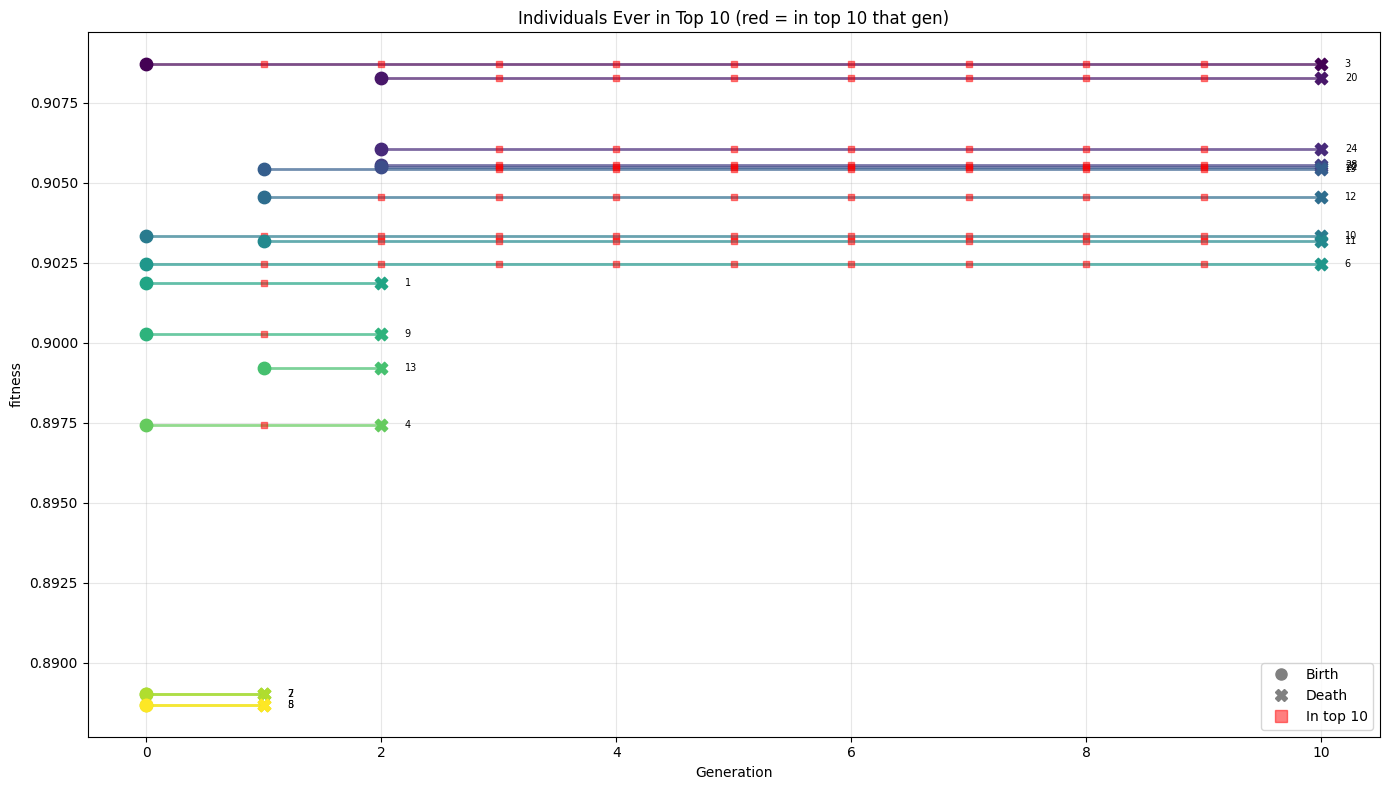

In [10]:
# If it's called 'fitness_' or something else                                                                                                     
plot_top_lifespans(gen_df, config, column='fitness', top_x=10)                                                                                   
                                                                                                                                                
# Also, verify gen_df has the right data:                                                                                                           
                                                                                                                                                
# Check a few individuals' lifespans in gen_df                                                                                                    
sample_ids = gen_df.reset_index()['id'].unique()[:5]                                                                                   
for ind_id in sample_ids:                                                                                                                         
    ind_data = gen_df.reset_index()                                                                                                               
    ind_data = ind_data[ind_data['id'] == ind_id]                                                                                      
    print(f"ID {ind_id}: gens {ind_data['gen'].min()} - {ind_data['gen'].max()}")

In [11]:
data['time_of_death']

0      2
1      1
2     10
3      2
4      1
      ..
95    10
96    10
97    10
98    10
99    10
Name: time_of_death, Length: 100, dtype: int64

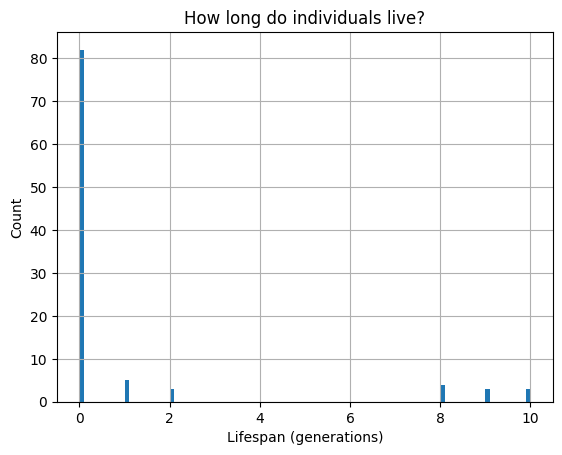

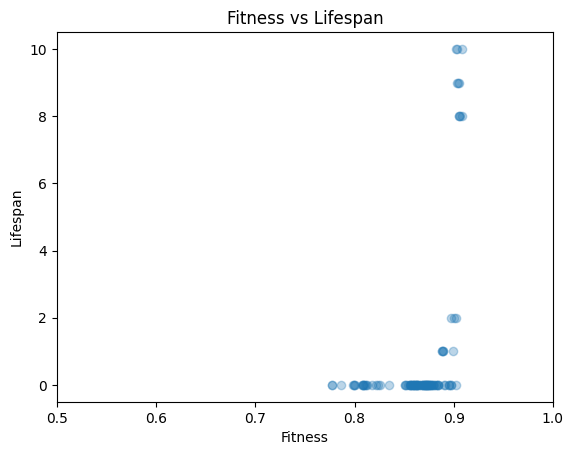

In [12]:
                                                                                                                                     # Lifespan distribution                                                                                                                           
data['lifespan'] = data['time_of_death'] - data['time_of_birth']                                                                                  
data['lifespan'].hist(bins=100)                                                                                                                    
plt.xlabel('Lifespan (generations)')                                                                                                              
plt.ylabel('Count')                                                                                                                               
plt.title('How long do individuals live?')                                                                                                        
plt.show()                                                                                                                                        
                                                                                                                                                
# Lifespan vs fitness - do better individuals live longer?                                                                                        
plt.scatter(data['fitness_'], data['lifespan'], alpha=0.3)                                                                                        
plt.xlabel('Fitness')                                                                                                                             
plt.ylabel('Lifespan')                                                                                                                            
plt.title('Fitness vs Lifespan')  
plt.xlim(0.5, 1)                                                                                                             
plt.show()

In [13]:
gen_df.loc[(5, 0)]

id                                                               3
alive                                                            1
time_of_birth                                                    0
time_of_death                                                   10
requires_eval                                                    0
fitness                                                   0.908699
requires_init                                                    0
genotype         [[-2025.7263864901433, 7972.971232040092, 3567...
tags             {"ctk_string": "C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(...
ctk_string       C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(B6[b(B6H4)]B1H2H...
novelty                                                   0.908699
archived                                                       NaN
Name: (5, 0), dtype: object

In [14]:
gen_df.loc[5].iloc[:3]['ctk_string']

rank
0    C[f(H7B[r(B1)b(B4)l(B5[r(B3[l(B6[b(B6H4)]B1H2H...
1    C[f(H6)]<b(BB3[l(B6[b(B2[b(B2[r(B1[t(B3)]H5)])...
2    C[f(BHH)]<b(BB6[b(B3)l(B6[b(B6H4H5)]B5[l(B7[b(...
Name: ctk_string, dtype: object

In [15]:
print(gen_df.iloc[5].iloc[0])

4


In [16]:
gen_df.loc[5]                                                                                                                                     
                                                                                                                                                    
# Specific individual in specific generation                                                                                                      
gen_df.loc[(5, 123)]                                                                                                                              
                                                                                                                                                
# Stats per generation (automatically groups by outer index)                                                                                      
gen_df.groupby('gen')[['fitness', 'novelty', 'speed']].mean()                                                                                   
                                                                                                                                                
# Plot easily                                                                                                                                     
gen_df.groupby('gen')[['fitness', 'diversity']].mean().plot()

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:381 │
│ 2 in get_loc                                                                                     │
│                                                                                                  │
│   3809 │   │   """                                                                               │
│   3810 │   │   casted_key = self._maybe_cast_indexer(key)                                        │
│   3811 │   │   try:                                                                              │
│ ❱ 3812 │   │   │   return self._engine.get_loc(casted_key)                                       │
│   3813 │   │   except KeyError as err:                                                           │
│   3814 │   │   │   if isinstance(casted_key, slice) or (                                         │
│   3815 │   │   │   │   isinstance(casted_key, abc.Iterable)                                      │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:167                                                    │
│                                                                                                  │
│ in pandas._libs.index.IndexEngine.get_loc:196                                                    │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7088                                        │
│                                                                                                  │
│ in pandas._libs.hashtable.PyObjectHashTable.get_item:7096                                        │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 123

The above exception was the direct cause of the following exception:

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:4                                                                                    │
│                                                                                                  │
│    1 gen_df.loc[5]                                                                               │
│    2                                                                                             │
│    3 # Specific individual in specific generation                                                │
│ ❱  4 gen_df.loc[(5, 123)]                                                                        │
│    5                                                                                             │
│    6 # Stats per generation (automatically groups by outer index)                                │
│    7 gen_df.groupby('gen')[['fitness', 'novelty', 'speed']].mean()                               │
│                                                                                                  │
│ /home/salo/projects/ariel-zoo/.venv/lib/python3.12/site-packages/pandas/core/indexing.py:1185 in │
│ __getitem__                                                                                      │
│                                                                                                  │
│   1182 │   │   │   key = tuple(com.apply_if_callable(x, self.obj) for x in key)                  │
│   1183 │   │   │   if self._is_scalar_access(key):                                               │
│   1184 │   │   │   │   return self.obj._get_value(*key, takeable=self._takeable)                 │
│ ❱ 1185 │   │   │   return self._getitem_tuple(key)                                               │
│   1186 │   │   else:                                                       

---

In [ ]:
# import matplotlib.pyplot as plt                                                                                                                   
                                                                                                                                                
# # Group by generation and get fitness stats                                                                                                       
# stats = data.groupby('generation')['fitness'].agg(['mean', 'min', 'max', 'std'])                                                                  
                                                                                                                                                
# # Plot fitness                                                                                                                                    
# fig, ax = plt.subplots(figsize=(10, 6))                                                                                                           
# ax.plot(stats.index, stats['mean'], label='Mean', color='blue')                                                                                   
# ax.fill_between(stats.index, stats['mean'] - stats['std'], stats['mean'] + stats['std'],                                                          
#                 alpha=0.2, color='blue', label='±1 Std')                                                                                          
# ax.plot(stats.index, stats['max'], label='Max', color='green', linestyle='--')                                                                    
# ax.plot(stats.index, stats['min'], label='Min', color='red', linestyle='--')                                                                      
# ax.set_xlabel('Generation')                                                                                                                       
# ax.set_ylabel('Fitness')                                                                                                                          
# ax.legend()                                                                                                                                       
# ax.set_title('Fitness over Generations')                                                                                                          
# plt.show()

In [ ]:
                                                                                                                                                
                                                                                                                                                
gen_df.head()  

### Plot fitness and stored values

In [ ]:
import json                                                                                                                                       
                                                                                                                                                
min_gen = int(data['time_of_birth'].min())                                                                                                        
max_gen = int(data['time_of_death'].max())                                                                                                        
                                                                                                                                                
# Compute stats for each generation                                                                                                               
stats_per_gen = []                                                                                                                                
for gen in range(min_gen, max_gen + 1):                                                                                                           
    alive = data[(data['time_of_birth'] <= gen) & (data['time_of_death'] >= gen)]                                                                 
                                                                                                                                                
    row = {                                                                                                                                       
        'generation': gen,                                                                                                                        
        'pop_size': len(alive),                                                                                                                   
        'fitness_mean': alive['fitness_'].mean(),                                                                                                  
        'fitness_max': alive['fitness_'].max(),                                                                                                    
        'fitness_min': alive['fitness_'].min(),                                                                                                    
        'fitness_std': alive['fitness_'].std(),                                                                                                    
    }                                                                                                                                             
                                                                                                                                                
    # Add tag values if they exist (parse JSON if needed)                                                                                         
    if 'tags' in alive.columns and len(alive) > 0:                                                                                                
        # Parse tags if JSON string                                                                                                               
        tags = alive['tags'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)                                                          
                                                                                                                                                
        for tag_name in ['diversity', 'speed', 'novelty']:  # adjust these                                                                        
            if tags.apply(lambda t: tag_name in t if t else False).any():                                                                         
                values = tags.apply(lambda t: t.get(tag_name) if t else None).dropna()                                                            
                if len(values) > 0:                                                                                                               
                    row[f'{tag_name}_mean'] = values.mean()                                                                                       
                    row[f'{tag_name}_max'] = values.max()                                                                                         
                                                                                                                                                
    stats_per_gen.append(row)                                                                                                                     
                                                                                                                                                
stats_df = pd.DataFrame(stats_per_gen)                                                                                                            
# stats_df                                                                                                                                          
                                                                                                                                                
# Then plot:                                                                                                                                        
                                                                                                                                                
fig, ax = plt.subplots(figsize=(10, 6))                                                                                                           
                                                                                                                                                
ax.plot(stats_df['generation'], stats_df['fitness_mean'], label='Mean', color='blue')                                                             
ax.fill_between(stats_df['generation'],                                                                                                           
                stats_df['fitness_mean'] - stats_df['fitness_std'],                                                                               
                stats_df['fitness_mean'] + stats_df['fitness_std'],                                                                               
                alpha=0.2, color='blue')                                                                                                          
ax.plot(stats_df['generation'], stats_df['fitness_max'], '--', label='Max', color='green')                                                        
ax.plot(stats_df['generation'], stats_df['fitness_min'], '--', label='Min', color='red')                                                          
                                                                                                                                                
ax.set_xlabel('Generation')                                                                                                                       
ax.set_ylabel('Fitness')                                                                                                                          
ax.legend()                                                                                                                                       
plt.show()                                                                                                                                        
                                                                                                                                                
# What tag names do you have? Check with:                                                                                                           
data['tags'].iloc[0]  # See structure of one tag

In [ ]:
# Fitness plot

In [ ]:
# Speed plot

In [ ]:
# Diversity plot

In [ ]:
# All plot 

### Get population per generation

The way ARIEL keeps track of individuals is not in the form of a list for each generation like it is more usually used in EAs. Normally in EAs, the population is represented as a list holding the "current alive population". This means that if you want more detailed data on individuals that did not survive to the end of the evolution loop you do not have that data.

Since we have kept track of all individuals to ever exist in the experiment in the database, we can pull that data and use it to get statistics about the experiment. But, since we don't have the list of individuals per generation, we need to make it. 

We can do that using the `time_of_birth` and `time_of_death` values for each individual.

In [ ]:
# Get minimum and maximum generation number
min_gen = int(data['time_of_birth'].min())
max_gen = int(data['time_of_death'].max())

# Get all individuals that are alive in each generation
population_per_gen = {
    gen: data.loc[(data['time_of_birth'] <= gen) & (data['time_of_death'] >= gen), 'id'].tolist()
    for gen in range(min_gen, max_gen + 1)
}

# Structure dataframe for easier viewing
pop_df = pd.DataFrame({
    'generation': list(population_per_gen.keys()),
    'individuals': list(population_per_gen.values()),
    'pop size': [len(v) for v in population_per_gen.values()]
    })

pop_df

Now that we have the list of the ids of each individual per generation, we can start querying information from the data to get deeper insights. For this example we will extract the mean and best (min) fitness and standard deviation of the fitness per generation. 

In [ ]:
# Get the fitness of every individual
fitness_by_id = data.set_index('id')['fitness_']

# Initialise lists
means = []
stds = []
maxs = []

# Get data from dataframe
for gen in pop_df['generation']:
    ids = population_per_gen.get(int(gen), [])
    if not ids:
        means.append(np.nan)
        stds.append(np.nan)
        maxs.append(np.nan)
        continue

    fits = fitness_by_id.reindex(ids).dropna().astype(float).values

    # If there is no data, initialise it as nan to avoid erors
    if fits.size == 0:
        means.append(np.nan)
        stds.append(np.nan)
        maxs.append(np.nan)
    
    # If there is data, add it to the list
    else:
        means.append(float(np.mean(fits)))
        stds.append(float(np.std(fits, ddof=0)))
        maxs.append(float(np.min(fits)))

# Add data to separate columns
pop_df['fitness_mean'] = means
pop_df['fitness_std'] = stds
pop_df['fitness_best'] = maxs

# Show dataframe
pop_df

### Plotting

Now that we have the mean and best fitness and standard deviation per generation, we can use them to plot the fitness progression 

In [ ]:
# Create a copy of dataframe
df = pop_df.copy()

# Create mast to avoid missing data 
# if the evolution process was done correctly this should not change anything.
# This mask cold be used to get custom data out of the dataframe
mask = df['fitness_mean'].notna()

# Get data according to the mask
x = df.loc[mask, 'generation']
mean = df.loc[mask, 'fitness_mean']
std = df.loc[mask, 'fitness_std']
maxv = df.loc[mask, 'fitness_best']

# Generate line plot of fitness per generation
plt.figure(figsize=(10, 5))
plt.plot(x, mean, label='Fitness mean', color='C0', linewidth=2)
plt.plot(x, maxv, label='Fitness best', color='C1', linestyle='--', linewidth=2)
plt.fill_between(x, mean - std, mean + std, color='C0', alpha=0.25, label='Mean ± Std')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness statistics per generation')
plt.legend()
plt.grid(alpha=0.3)
plt.yticks(range(0, int(max(df["fitness_mean"]) + 5), 2))
plt.tight_layout()
plt.show()